
## K-means Clustering vs. Mean-shift Clustering

#### Jodie Crocker
#### Graduate Student, Department of Civil, Architectural and Environmental Engineering, Cockrell School of Engineering 

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The University of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Ademide Mabadeje, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/ademidemabadeje/)


### Executive Summary

This workflow serves to demonstrate the differences between k-means clustering, which is discussed in the Subsurface Machine Learning course, and mean-shift clustering. Two sets of data are provided that show situations in which one clustering method may be preferable to the other. Animations of the clustering methods are provided to illustrate the performance of either method and an iteractive section is also included that demonstrates the sensitivity of mean-shift clustering to its bandwidth parameter. Based on the results of this workflow, it seems that mean-shift clustering is a viable alternative to k-means clustering when the number of clusters is unknown (i.e., no assumption of *k* is required), but is less effective if the data are all evenly dispersed in the feature space.

#### Import Packages
Several standard packages are imported to use DataFrames, ndarrays, and to provide plots/animations. Additionally, sci-kit-learn (sklearn) is imported for clustering and widgets are imported for interactivity.

In [1]:
%matplotlib notebook                                
import math                                         # basic calculations like square root
import numpy as np                                  # numpy methods for manipulating arrays
import pandas as pd                                 # DataFrames for tabular data
from matplotlib.animation import FuncAnimation      # for creating animations
import matplotlib.pyplot as plt                     # general plotting methods
import matplotlib.cm as cm                          # color maps
from matplotlib.colors import Normalize             # for normalizing color maps
from sklearn import cluster                         # k-means clustering and means-shift clustering methods
from sklearn.datasets import make_blobs             # for creating clustered datasets (blobs) 
from ipywidgets import widgets                      # widgets and interactivity                        
from ipywidgets import Layout
from ipywidgets import VBox, HBox

### Functions
The following functions are used to manually perform mean-shift clustering. These methods were modified from Eric Chio's workflow for building a meanshift method, found [here](https://github.com/log0/build-your-own-meanshift/blob/master/Meanshift%20In%202D.ipynb).

In [2]:
# Define an RBF or Gaussian kernel:
def kernel(dist, bandwidth, method):
    if method == 'RBF':
        val = np.exp(-dist/(2*bandwidth**2))
    else:
        val = (1/(bandwidth*math.sqrt(2*math.pi)))*np.exp(-0.5*((dist/bandwidth))**2)
    return val

# Define method to weight points, such that they shift towards higher density locations:
def mean_shift(data, bandwidth, method, n_iter):
    new_data = np.copy(data)
    for j in range(n_iter):
        for i, x in enumerate(new_data): 
            # Compute Euclidean distance between a point and all other points:
            dist = np.sqrt(((x - new_data)**2).sum(axis=1))
            
            # Find weight of each point for shifting:
            weights = kernel(dist, bandwidth, method)
            
            # Shift points based on weighted average:
            new_data[i] = (np.expand_dims(weights, 1)*new_data).sum(axis=0) / weights.sum()
    return new_data

### Load Data

The following workflow uses two datasets created by Professor Michael Pyrcz (@GeostatsGuy). The first dataset, '12_sample_data.csv' (located [here](https://github.com/GeostatsGuy/GeoDataSets/blob/master/12_sample_data.csv)), is a comma delimited file containing a multivariate spatial dataset with:
* X and Y coordinates ($m$)
* facies 0 and 1 
* porosity (fraction)
* permeability ($mD$)
* acoustic impedance ($kg/m^2s*10^3$).

The second dataset, 'nonlinear_facies_v3.csv' (located [here](https://github.com/GeostatsGuy/GeoDataSets/blob/master/nonlinear_facies_v3.csv)), is a comma delimited file containing a multivariate dataset with:
* facies 1, 2, and 3
* porosity (percent)
* acoustic impedance ($kg/m^2s*10^3$). 

Additional datasets may be found at the [GeostatsGuy Github](https://github.com/GeostatsGuy/GeoDataSets).

The following features will be used in this workflow:

* **porosity** - fraction of rock void
* **acoustic impedence** - product of sonic velocity and rock density in units of $kg/m^2s*10^3$

Note that the facies feature will also be used only for visualizing the dataset and will not be used during clustering.

Dataset 1 illustrates a dataset that works well with k-means clustering, whereas dataset 2 is more suited for mean-shift clustering, assuming the input parameters have been carefully selected.

In [3]:
# Load datasets: 
dataset = 1

if dataset == 1:
    df = pd.read_csv(r'https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/12_sample_data.csv',index_col=0) 
    df = df.iloc[:,[2,3,5]]
elif dataset == 2:
    df = pd.read_csv(r'https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/nonlinear_facies_v3.csv')  
    df = df.iloc[:,[3,1,2]]
    df = df.rename(columns = {'Por': 'Porosity'})
    df['Porosity'] = df['Porosity']/100
    df.loc[(df.Facies == 3),'Facies'] = 0

### K-means Clustering vs. Mean-shift Clustering

This workflow demonstrates both k-means clustering and mean-shift clustering. 

This workflow is broken up into the following primary steps:

1. simple demonstration of k-means clustering using sklearn
2. manual demonstration of mean-shift clustering
3. interactive section showing sensitivity of mean-shift clustering to its bandwidth parameter
4. demonstration of mean-shift clustering using sklearn

This allows for seeing both types of clustering in action, but also provides an example of using sklearn to perform these clustering methods in more comprehensive machine learning workflows.

#### Plotting Parameters
This cell defines some plotting parameters and a colormap.

In [4]:
plt.rc('xtick', labelsize=14); plt.rc('ytick', labelsize=14) 
plt.rc('axes', titlesize=16); plt.rc('axes', labelsize=14) 
#cmap = cm.jet
cmap = cm.inferno

#### Viewing the Data
An option is included to add noise to the previously loaded dataset. Note that this is for demonstration only; adding noise reduces trends in the dataset, which affects clustering. The known facies are also used here to show the truth model, but will not be used when performing clustering.

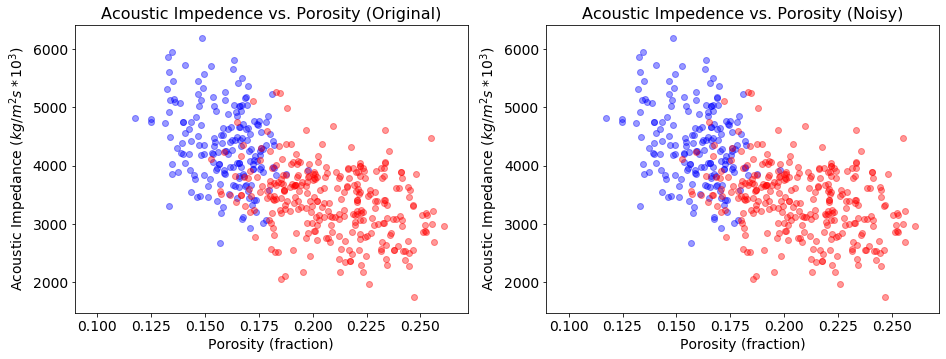

In [5]:
# (Optional) Add random noise to dataset:
np.random.seed(seed = 15)                                 # set the random number seed
noise_stdev = 0                                           # standard deviation of noise; set to 0 to use original data

# Plot data:
%matplotlib inline

# Separate data based on facies:
df0 = df[df['Facies'] == 0]; df1 = df[df['Facies'] == 1]; df2 = df[df['Facies'] == 2]

# Original data:
plt.subplot(121)
plt.scatter(df0['Porosity'], df0['AI'], c = "blue", alpha = 0.4)
plt.scatter(df1['Porosity'], df1['AI'], c = "red", alpha = 0.4)
plt.scatter(df2['Porosity'], df2['AI'], c = "green", alpha = 0.4)
plt.title('Acoustic Impedence vs. Porosity (Original)'); plt.xlabel('Porosity (fraction)'); plt.ylabel('Acoustic Impedance ($kg/m^2s*10^3$)')

# Data with noise:
plt.subplot(122)
df['AI'] = df['AI'] + np.random.normal(loc = 0, scale = noise_stdev, size = len(df))
df0 = df[df['Facies'] == 0]; df1 = df[df['Facies'] == 1]; df2 = df[df['Facies'] == 2]
plt.scatter(df0['Porosity'], df0['AI'], c = "blue", alpha = 0.4)
plt.scatter(df1['Porosity'], df1['AI'], c = "red", alpha = 0.4)
plt.scatter(df2['Porosity'], df2['AI'], c = "green", alpha = 0.4)
plt.title('Acoustic Impedence vs. Porosity (Noisy)'); plt.xlabel('Porosity (fraction)'); plt.ylabel('Acoustic Impedance ($kg/m^2s*10^3$)')
plt.subplots_adjust(left = 0.0, bottom = 0.0, right = 2.0, top = 1.0, wspace = 0.2, hspace = 0.2)
plt.show()

#### Normalizing the Data
Clustering techniques rely on distances between data points. Therefore, we normalize the data to:
* transform the range of each feature to have a (minimum, maximum) = (0, 1)
* remove the influence of the features' original magnitudes and ranges

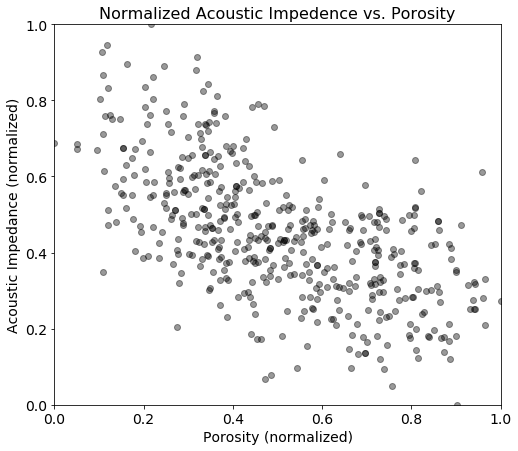

In [6]:
# Normalize data:
pormin = df['Porosity'].min(); pormax = df['Porosity'].max()
AImin = df['AI'].min(); AImax = df['AI'].max()
df['Norm_Porosity'] = (df['Porosity'] - pormin)/(pormax - pormin)
df['Norm_AI'] = (df['AI'] - AImin)/(AImax - AImin)

# Plot normalized data:
fig = plt.figure(figsize = (8,7))
plt.scatter(df['Norm_Porosity'], df['Norm_AI'], c = "black", alpha = 0.4)
plt.title('Normalized Acoustic Impedence vs. Porosity'); plt.xlabel('Porosity (normalized)'); plt.ylabel('Acoustic Impedance (normalized)')
plt.xlim(0,1.0); plt.ylim(0,1.0)
plt.show()

#### K-means Clustering Demonstration
For a more in-depth analysis of k-means clustering, refer to the extended demonstration found [here](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_Clustering.ipynb), which is provided as a supplemental workflow for Professor Pyrcz's Subsurface Machine Learning course.

As a brief summary, remember that several assumptions are made when performing k-means clustering:
* requires an input parameter of *k* number of clusters
* clusters are spherical and isotropic
* each data point has an equal prior probability of being included in a cluster
* clusters are created to be similar in size/frequency of data

When looking at either dataset, notice that:
* Dataset 1 has evenly dispersed data and is spherical, meaning k-means clustering may perform well
* Dataset 2 has non-spherical clusters of data with varying density, meaning k-means clustering may not perform well

While k-means clustering is not the focus of this workflow, the animation created below is provided as a comparison to mean-shift clustering performed later.

The following cell generates the data that will be used for the animation. While the default *k* is set to 5, this is for demonstration purposes. 2 and 3 clusters can be used with Dataset 1 and 2, respectively, to see how k-means clustering compares to the truth model.

In [7]:
# Choose number of clusters for k-means clustering:
n_clusters = 6

# Initialize arrays used for animation:
centroids = []
colors = []

# Initialize starting locations, difference/tolerance metrics:
centroids_i = np.random.rand(n_clusters,2)
centroids.append(centroids_i)
dif = centroids_i
tol = 1e-10

# Define color mapping for centroids and data:
norm = Normalize(vmin = 0, vmax = n_clusters)
colors_cent = [cmap(norm(i)) for i in range(0,n_clusters)]

# Perform k-means clustering until convergence based on tolerance while saving each iteration:
while np.any(dif) > tol:
    kmeans = cluster.KMeans(n_clusters, init = centroids_i, n_init = 1, max_iter = 1).fit(df[['Norm_Porosity','Norm_AI']])
    dif = np.abs(centroids_i - kmeans.cluster_centers_)
    centroids_i = kmeans.cluster_centers_
    centroids.append(centroids_i)
    color = [cmap(norm(i)) for i in kmeans.labels_]
    colors.append(color)

Now an animation can be created using the location of the centroids and clusters from each iteration.

<IPython.core.display.Javascript object>


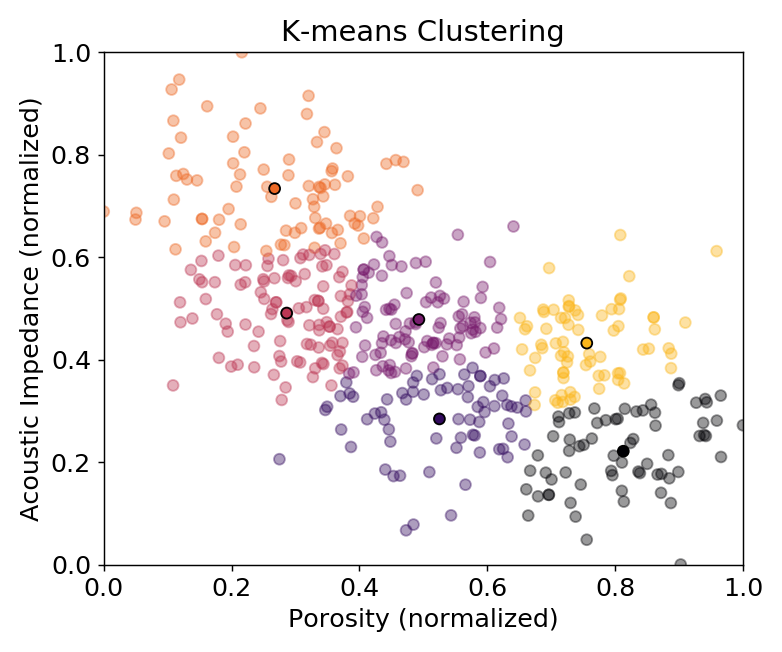

In [8]:
%matplotlib qt5
fig = plt.figure(figsize = (6,5), dpi=100, tight_layout=True)
ax = plt.gca()
ax.set_xlim(0,1); ax.set_ylim(0,1)
ax.set_xlabel('Porosity (normalized)'); ax.set_ylabel('Acoustic Impedance (normalized)'); ax.set_title('K-means Clustering')

# Construct scatter plot with initial data and starting centroids:
data = ax.scatter(df['Norm_Porosity'], df['Norm_AI'], c = colors[0], alpha = 0.4)
cents = ax.scatter(centroids[0][:,0], centroids[0][:,1], c = colors_cent, edgecolors = 'k')

# Method required to create animation:
def update(frame_number):
    current_index = frame_number

    # Update the data with new colors based on new centroid locations:
    cents.set_offsets(centroids[current_index])
    data.set_color(colors[current_index])


# Perform the animation:
animation = FuncAnimation(fig, update, interval=500)
plt.show()

When viewing the animation, note that:
* centroids shift position to allow for spherical and evenly dispersed clusters
* this is true for any *k* number of clusters (try a larger amount of clusters)

Therefore, the clusters that are created are heavily influenced by the user-defined number of clusters.

### Mean-shift Clustering

Mean-shift clustering is similar to k-means clustering in that it:
* is applied as an unsupervised method for classification, as it assigns data points to clusters based on their proximity to high-density regions
* requires iterations, meaning data are shifted until there is no further update to the locations of each data point

Unlike k-means clustering, however, this method does not require an inital assumption of *k* clusters. Instead, this method looks at all data points and shifts them accordingly towards the mode, or the region with the highest density of data points. Therefore, mean-shift clustering determines the number of clusters solely based on the algorithm with respect to the data.

Considering a single data point $x_{0}$, the procedure can be described as follows:
1. Euclidean distance between $x_{0}$ and all other data points is calculated.
2. A kernel is chosen to estimate the underlying density distribution of the data in the feature space, such as the radial basis function or Gaussian kernel.
3. The kernel is applied at $x_{0}$'s location. The previously calculated distance is used with the kernel to determine a weighted average, or mean, of all other data points with respect to $x_{0}$. $x_{0}$ is then shifted to this new location, which represents its closeness to the other data points. 

This procedure then repeats for each $x_{i}$ in a given iteration. Clustering is finished after a set number of iterations has been reached or until all points no longer move. Note that this is the basic procedure for mean-shift clustering, which is implemented in the functions listed at the beginning of this workflow. However, modifications can be made to change the number of neighboring points to consider in Step 1 or to the type of kernel used in Step 2.

#### Mean-shift Clustering Demonstration

The following cell generates the data that will be used for the animation. The following are required inputs:
* bandwidth - determines the size of the region the kernel is applied to
* method - can either use the radial basis function (RBF) kernel or Gaussian kernel
* iterations - number of times to repeat mean-shifting

For Dataset 1, the recommended inputs are bandwidth = 0.15, method = 'RBF', and iterations = 10.
For Dataset 2, the recommended inputs are bandwidth = 0.15, method = 'RBF', and iterations = 15.

In [28]:
# Choose size of bandwidth, type of kernel, and number of iterations:
bandwidth = 0.15
method = 'RBF'
iterations = 10
cmap = cm.inferno_r

# Create 2D array with features:
init_data = np.array(df[['Norm_Porosity','Norm_AI']])

# Initialize arrays used for animation:
new_loc = []
new_loc.append(init_data)
mean_colors = []


# Perform mean-shift clustering step-by-step:
for i in range(iterations):
    new_data = mean_shift(new_loc[i], bandwidth = bandwidth, method = method, n_iter = 1)
    new_loc.append(new_data)
    
    # Create normalized color map based on any number of clusters
    norm = Normalize(vmin = 0, vmax = np.max((new_loc[-1][:,0]*20+new_loc[-1][:,1]*5)))
    mean_color = [cmap(norm(i)) for i in new_loc[-1][:,0]*20+new_loc[-1][:,1]*5]
    mean_colors.append(mean_color)

Now the animation can be created:

<IPython.core.display.Javascript object>


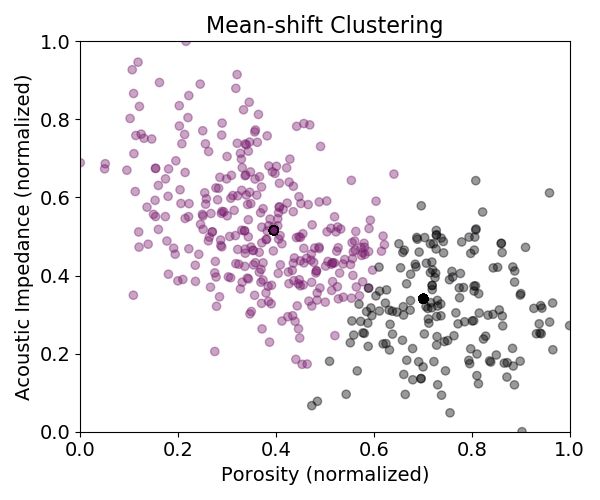

In [31]:
%matplotlib qt5
fig = plt.figure(figsize = (6,5), dpi=100, tight_layout=True)
ax = plt.gca()
ax.set_xlim(0,1); ax.set_ylim(0,1)
ax.set_xlabel('Porosity (normalized)'); ax.set_ylabel('Acoustic Impedance (normalized)'); ax.set_title('Mean-shift Clustering')

# Construct scatter plot with initial data and starting centroid locations:
data = ax.scatter(init_data[:, 0], init_data[:, 1], c = mean_color, alpha = 0.4)
cents = ax.scatter(new_loc[0][:,0], new_loc[0][:,1], c = mean_color, edgecolors = 'k')

def update(frame_number):
    current_index = frame_number

    # Update the data with new colors based on new locations:
    cents.set_offsets(new_loc[current_index])
    cents.set_facecolor(mean_colors[current_index])
    data.set_facecolor(mean_colors[current_index])

# Perform the animation:
animation = FuncAnimation(fig, update, interval=400)
plt.show()

When using Dataset 1 and the suggested input parameters, note that:
* clusters are not equal in density
* two clusters are provided, although they are not divided the same as the truth model or the k-means clustering result

For Dataset 2:
* clusters are not equal in density with a very sparse cluster formed at the top left
* the three main clusters are not spherical and provide clusters more similar to the truth model compared to the results of k-means clustering
* the very dense cluster in the top right absorbs part of the middle cluster

Therefore, advantages of using mean-shift clustering include:
* no need to assume a *k* number of clusters
* does not assume a shape for the clusters

Despite the advantages, we will see in the following interactive session that the results are highly dependent on the bandwidth parameter and, to a lesser extent, the number of iterations used. First, the layout is initialized in the following cell.

In [51]:
%matplotlib inline
#l = widgets.Text(value = 'Interactive Mean-Shift Clustering Demonstration',layout = Layout(width = '950px', height = '30px'))

n_iterations = widgets.IntSlider(min = 0, max = 50, value = 0, step = 1, description = 'n_iterations',orientation = 'horizontal', style = {'description_width': 'initial'}, continuous_update=False)
bandwidth = widgets.FloatSlider(min = 0.050, max = 1, value = 0.05, step = 0.005, readout_format='.3f', description = 'bandwidth',orientation ='horizontal',style = {'description_width': 'initial'}, continuous_update=False)

ui = widgets.HBox([n_iterations,bandwidth],)
ui2 = widgets.VBox([ui],)

def run_plot(n_iterations, bandwidth):  
    # Create the dataset:
    blob,_ = make_blobs(n_samples = 200, n_features = 2, random_state = 0)
    blob[:,0] = (blob[:,0]-np.min(blob[:,0]))/(np.max(blob[:,0]) - np.min(blob[:,0]))
    blob[:,1] = (blob[:,1]-np.min(blob[:,1]))/(np.max(blob[:,1]) - np.min(blob[:,1]))
    
    new_blob = mean_shift(blob, bandwidth = bandwidth, method = 'RBF', n_iter = n_iterations)
    color = [cmap((i)) for i in new_blob[:,0]]
    
    fig = plt.figure(figsize = (12,12))
    plt.scatter(blob[:, 0], blob[:, 1], c = color, alpha = 0.4)
    plt.scatter(new_blob[:,0], new_blob[:,1], c = color, edgecolors = 'k')
    plt.xlim(0,1);plt.ylim(0,1)
    plt.title("Mean Shift Clustering")
    plt.xlabel('Porosity (normalized)'); plt.ylabel('Acoustic Impedance (normalized)')

    plt.show(fig)
    
# Connect the function to the widgets:  
interactive_plot = widgets.interactive_output(run_plot, {'n_iterations':n_iterations,'bandwidth':bandwidth})
interactive_plot.clear_output(wait = True)

For simplicity, a relatively sparse dataset is created with three known clusters. When interacting with the bandwidth and number of iterations, note how:
* as the bandwidth increases, clusters form more rapidly, as more points are weighted heavily when performing the mean-shift
* if the bandwidth is too small, many clusters are formed, although these "clusters" may consist of one data point
* while not a true parameter, the number of iterations influences the rate at which clusters are formed and data points converge (i.e., clusters begin to merge for a large number of iterations)

Therefore, while a benefit of mean shift clustering is that an initial value of *k* is not needed, the final clusters that are formed are highly sensitive to the bandwidth input. For example, 9 iterations and a bandwidth of 0.15 form three clusters, but 50 iterations with a bandwidth of 0.125 form the same clusters. Therefore, care must be taken when choosing the bandwidth in addition to a reasonable number of iterations.

### Interactive Machine Learning Mean Shift Clustering Demonstation 

#### Jodie Crocker, Graduate Student, Department of Civil, Architectural and Environmental Engineering, Cockrell School of Engineering 

Supervised by Michael Pyrcz, Associate Professor, University of Texas at Austin, as part of the Subsurface Machine Learning course. 

### The Inputs

* **n_iterations** - number of iterations of mean shift and remove redundant prototypes
* **bandwidth** - bandwidth used for the radial basis function kernel to calculate local density 

In [52]:
display(ui2, interactive_plot)                           # display the interactive plot

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Figure size 864x864 with 1 Axes>', 'i…

#### Mean-shift Clustering with Sklearn

Now that mean-shift clustering has been discussed extensively, a simple example using sklearn is provided. In the previous method, all points were used as an initial kernel location when calculating the mean-shift of each point. However, unless these kernel locations are explictly defined, the sklearn method will use a nearest-neighbor approach to select the initial kernel locations as a function of the bandwidth input. By doing so, the algorithm is sped up considerably, but the results are slightly different from those shown previously.

In the following cell, both mean-shift clustering and k-means clustering are performed on the same dataset defined previously. Recall that for Dataset 1, the recommended inputs are bandwidth = 0.15 and iterations = 10, while for Dataset 2, bandwidth = 0.15 and iterations = 15. Note how the following observations are confirmed:
* both methods may perform similarly for evenly distributed data, given careful selection of the bandwidth used with mean-shift clustering
* mean-shift clustering may provide the same number of clusters as k-means clustering without the need for assuming *k* clusters
* mean-shift clustering provides relatively reasonable clusters compared to k-means clustering when unevenly distributed or non-spherical data are present in the feature space

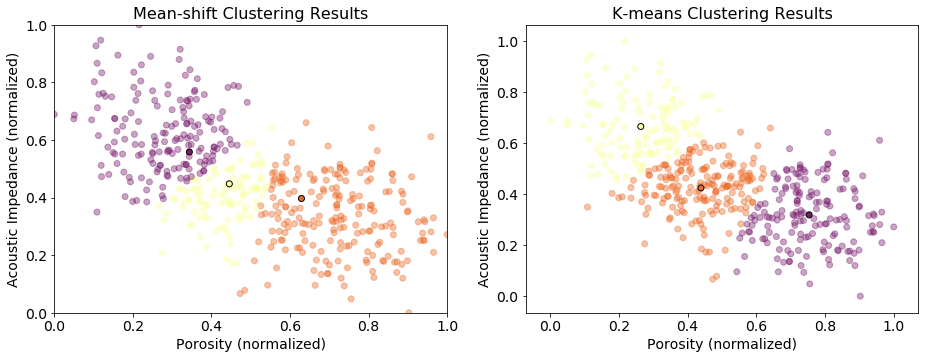

In [13]:
%matplotlib inline
# Choose size of bandwidth and number of iterations to use with mean-shift clustering:
bandwidth = 0.15
iterations = 10

# Choose number of clusters to use with k-means clustering:
n_clusters = 3

# Perform mean-shift clustering using scikit learn method and create colors for plotting:
m_shift = cluster.MeanShift(bandwidth = bandwidth, max_iter = iterations, cluster_all = True).fit(df[['Norm_Porosity','Norm_AI']])
m_cent = m_shift.cluster_centers_
norm = Normalize(vmin = 0, vmax = len(m_cent))
m_cent_color = [cmap(norm(i)) for i in range(0,len(m_cent))]
m_color = [cmap(norm(i)) for i in m_shift.labels_]

# Perform k-means clustering using scikit learn method and create colors for plotting:
k_means = cluster.KMeans(n_clusters).fit(df[['Norm_Porosity','Norm_AI']])
k_cent = k_means.cluster_centers_
norm = Normalize(vmin = 0, vmax = len(k_cent))
k_cent_color = [cmap(norm(i)) for i in range(0,len(k_cent))]
k_color = [cmap(norm(i)) for i in k_means.labels_]

# Plot mean-shift clustering results:
plt.subplot(121)
plt.scatter(df['Norm_Porosity'], df['Norm_AI'], c = m_color, alpha = 0.4)
plt.scatter(m_cent[:,0], m_cent[:,1], c = m_cent_color, edgecolors = 'k')
plt.title('Mean-shift Clustering Results'); plt.xlabel('Porosity (normalized)'); plt.ylabel('Acoustic Impedance (normalized)')
plt.xlim(0,1.0); plt.ylim(0,1.0)

# Plot k-means clustering results:
plt.subplot(122)
plt.scatter(df['Norm_Porosity'], df['Norm_AI'], c = k_color, alpha = 0.4)
plt.scatter(k_cent[:,0], k_cent[:,1], c = k_cent_color, edgecolors = 'k')
plt.title('K-means Clustering Results'); plt.xlabel('Porosity (normalized)'); plt.ylabel('Acoustic Impedance (normalized)')
plt.subplots_adjust(left = 0.0, bottom = 0.0, right = 2.0, top = 1.0, wspace = 0.2, hspace = 0.2)
plt.show()

### Results

When looking at either dataset, it is clear that k-means clustering and mean-shift clustering both have advantages and disadvantages. Dataset 1, which is a relatively spherical dataset with evenly distributed data, works better with k-means clustering, as mean-shift clustering tends to form one large cluster if the input parameters are not carefully selected. However, Dataset 2, which has nonspherical clusters and unevenly distributed data, works better with mean-shift clustering, as it is better able to capture the trends in the clusters compared to k-means clustering. Based on these results, mean-shift clustering seems ideal for situations in which the number of clusters is unknown, or the dataset does not follow the assumptions of k-means clustering.


I hope this was helpful,

Jodie Crocker

___________________

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
